# Random Forest Regressor Explained
### Jeanine Buyck

This is the code that was for illustration purposes in the article.

## Generate synthetic data for use in examples

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt

from math import pi

In [2]:
# custom modules

# this adds the parent dir to the path so we can import its modules
import sys
sys.path.insert(0,'..')

# this is how we'll generate data for our example
from synthetic_data.generate import sine_data

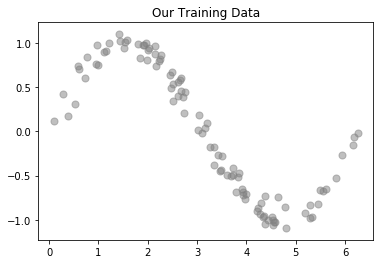

In [3]:
# generate synthetic data based on sine function
min_x = 0
max_x = 2 * pi
X, y = sine_data(
    min_x=min_x,
    max_x=max_x,
    n=100,
    amplitude=1,
    error_mean=0,
    error_std_dev=0.1
)

plt.scatter(X, y, alpha=.5, c='gray', s=50)
plt.title('Our Training Data')
plt.show()

In [4]:
# generate data for plotting model
X_model_plot = np.linspace(min_x, max_x, num=10000, endpoint=True)

## Build a few decision trees of various depths

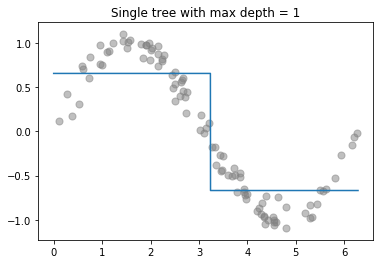

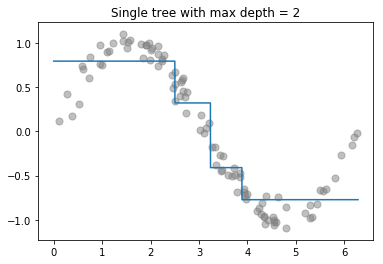

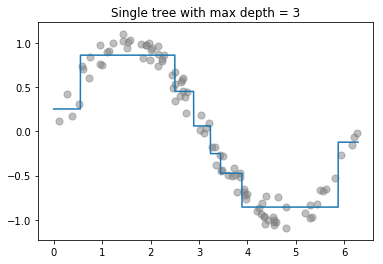

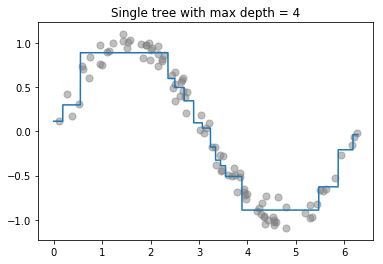

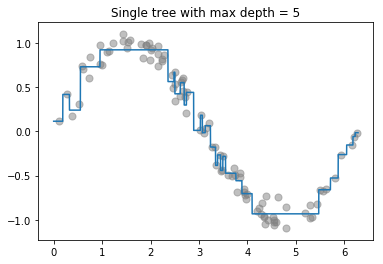

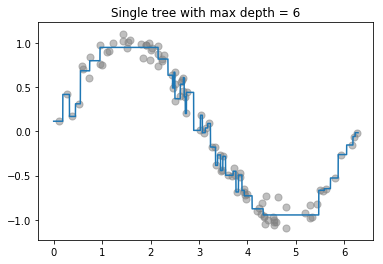

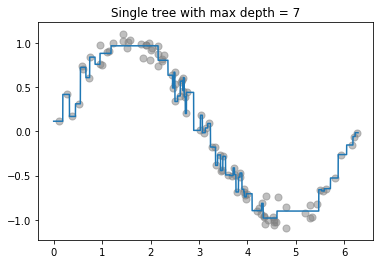

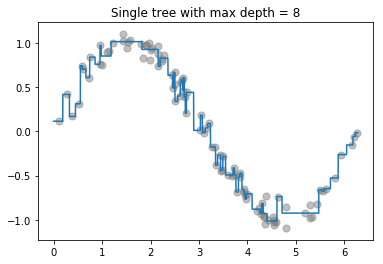

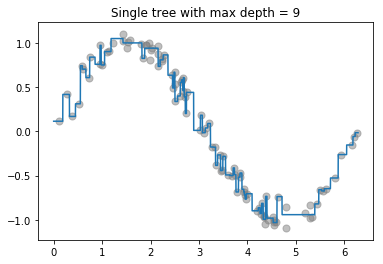

In [5]:
from sklearn.tree import DecisionTreeRegressor

for depth in range(9):
    max_depth = depth + 1  # off by one due to range behavior
    
    my_tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
    my_tree.fit(X.reshape(-1, 1), y)
    tree_depth = my_tree.get_depth()
    y_model_plot = my_tree.predict(X_model_plot.reshape(-1, 1))
    
    plt.scatter(X, y, alpha=.5, c='gray', s=50)
    plt.title(f'Single tree with max depth = {tree_depth}')
    plt.plot(X_model_plot, y_model_plot)
    plt.show()
    
    
# TODO replot so these plots are in a 3 x 3 grid

# TODO think about if this code belongs in a function in a module

## Build an ensemble of trees with the same max_depth, no randomness added in.

In [6]:
def ensemble_predict(X, trees):
    """Get predictions for X by averaging predictions from the trees."""
    
    # keep track of number of trees for computing the average later
    num_trees = len(trees)
    
    # start with zeros, we will add predictions to this for each tree
    y_hat_sum = np.zeros(len(X))
    
    # get the predictions for each tree and add to running sum
    for tree in trees:
        y_hat_sum += tree.predict(X.reshape(-1, 1))
        
    # divide by total number of trees to get the average
    y_hat = y_hat_sum / num_trees
    
    return y_hat

# # TODO erase later, for dev/debug only
# y_hat_ensemble = ensemble_predict(np.array([1, 2, 3]), [my_tree, my_tree])
# print(y_hat_ensemble)

# TODO think about if this code belongs in a function in a module

In [7]:
# TODO define function to train several trees, 
# each on the SAME data set, 
# and return them as a list

# TODO use max_depth = 3 as example and build 6 decision trees

# GOAL: see that the ensemble produces the same results as the individual tree

## Build an ensemble of trees with the same max_depth, but bootstrap the training data.

In [12]:
from sklearn.utils import resample
X_bootstrapped, y_bootstrapped = resample(X, y, replace=True)

-24.19056143537577
0.0


In [8]:
# TODO define function to train several trees, 
# each on a new BOOTSTRAPPED sample of the data set, 
# and return them as a list

# TODO try to build ensemble of trees for different max depths
# try: 1, 2, 3 for max depth

# ALSO try increasing numbers of trees in the ensemble:
# 2, 4, 8, 16, 32, 64

In [9]:
# GOAL: see that not only does the ensemble produce a different result,
#       but also the curve is becoming smoother and not overfitting the data.